# Chest X-ray Analysis for Pneumonia Detection

### Team : Final Project 16
| Student No  | First Name                  | Last Name     |
|-------------|-----------------------------|---------------|
| 9016986     | Keerthi                     | Gonuguntla    |
| 8965985     | Pradeepti                   | Kasam         |

#### **Problem Definition**

Pneumonia, a severe lung infection, can be life-threatening if not diagnosed and treated promptly.

Chest X-rays are a primary diagnostic tool, but interpreting them requires specialized expertise, which may not always be readily available. 

This creates a need for an automated, accurate method to assist in the detection of pneumonia.

**Goal**

To Develop a machine learning model that classifies chest X-ray images to detect the presence or absence of pneumonia. 

The aim is to provide a reliable diagnostic aid to healthcare professionals, enhancing diagnostic speed and accuracy.

#### **Kaggle Dataset**

[Chest X-Ray Analysis for pneumonia Detection](https://www.kaggle.com/datasets/damingo1/pneumonia-detection)

initial dataset ratios 

train - 89%

test - 10.99%

val - 0.003%

In [19]:
#importing required libraries
import os
import shutil
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D,MaxPooling2D, Flatten, Dense, Dropout, Input,GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

combining the train ,test and val data to perform preprocessing

In [ ]:
# Paths to original datasets
train_path = "chest_xray/train"
test_path = "chest_xray/test"
val_path = "chest_xray/val"

# Combined dataset path
combined_dataset_path = "combined_dataset"
normal_path = os.path.join(combined_dataset_path, "normal")
pneumonia_path = os.path.join(combined_dataset_path, "pneumonia")

# Create folders if they don't exist
os.makedirs(normal_path, exist_ok=True)
os.makedirs(pneumonia_path, exist_ok=True)

# Function to copy and rename files
def copy_and_rename_images(source_dir, target_dir, category):
    source_category_path = os.path.join(source_dir, category)
    target_category_path = os.path.join(target_dir, category)
    
    # Ensure the target folder exists
    os.makedirs(target_category_path, exist_ok=True)

    # Get the current count of files in the target directory to avoid overwriting
    current_count = len(os.listdir(target_category_path))

    # Enumerate files and rename them
    for idx, file_name in enumerate(os.listdir(source_category_path), start=current_count + 1):
        source_file = os.path.join(source_category_path, file_name)
        target_file = os.path.join(target_category_path, f"{category}_{idx:03d}.jpeg")
        
        # Copy the file
        shutil.copy(source_file, target_file)

# Process train, test, and val directories
for category in ["normal", "pneumonia"]:
    for source_dir in [train_path, test_path, val_path]:
        copy_and_rename_images(source_dir, combined_dataset_path, category)

print("Datasets combined and renamed successfully!")


Datasets combined and renamed successfully!


#### **Data Preprocessing**

1. To remove corrupted images

In [22]:
# Function to clean data by removing duplicates and corrupted images
def clean_data(dataset_path):
    image_files = []
    for category in ["normal", "pneumonia"]:
        category_path = os.path.join(dataset_path, category)
        for file_name in os.listdir(category_path):
            file_path = os.path.join(category_path, file_name)
            try:
                img = load_img(file_path)
                img.verify()  # Verifies that the image is not corrupted
                image_files.append(file_path)
            except Exception as e:
                print(f"Corrupted or invalid image: {file_path}")
                os.remove(file_path)  # Remove corrupted image
    return image_files

# Clean the combined dataset
image_count_before_cleaning = len(os.listdir(normal_path)) + len(os.listdir(pneumonia_path))
print("Image count before cleaning:", image_count_before_cleaning)
image_files = clean_data(combined_dataset_path)
print("Image count after cleaning:", len(image_files))

if len(image_files) == image_count_before_cleaning:
    print("No corrupted images found!")

Image count before cleaning: 5855
Image count after cleaning: 5855
No corrupted images found!


2. Split Data into train ,validation and test in ratios

   train - 60%

   test - 20%

   val - 20%

In [31]:
base_path = r"combined_dataset"
categories = ["normal", "pneumonia"]
splits = ["train", "test", "val"]
output_dir = os.path.join("Final_DataSet")

#Split ratio of the dataset 
#dataset is split into 60% train and 40% (test and validation)
train_ratio = 0.6
test_val_ratio = 0.4
#test and validation are split into 50% each
test_ratio = 0.5  

# Initializing counters for the split sizes
split_sizes = {"train": 0, "test": 0, "val": 0}

# Initializing total image counters
total_normal_images = 0
total_pneumonia_images = 0

# Creating output directories for splitting the data 
for split in splits:
    for category in categories:
        os.makedirs(os.path.join(output_dir, split, category), exist_ok=True)

# Printing the number of images before splitting
print("Before splitting:")
for category in categories:
    category_path = os.path.join(base_path, category)
    if not os.path.exists(category_path):
        print(f"Directory not found: {category_path}, skipping.")
        continue
    # Get list of all image files in the category folder
    files = os.listdir(category_path)
    files = [f for f in files if os.path.isfile(os.path.join(category_path, f))]
    category_image_count = len(files)
    # Add to total counts
    if category == "normal":
        total_normal_images = category_image_count
    elif category == "pneumonia":
        total_pneumonia_images = category_image_count
    print(f"{category.capitalize()} image count: {category_image_count}")
# Printing the total images in both categories before splitting
total_images = total_normal_images + total_pneumonia_images
print(f"Total image count: {total_images}")

# Splitting the images into train, test, and validation
for category in categories:
    category_path = os.path.join(base_path, category)
    if not os.path.exists(category_path):
        print(f"Directory not found: {category_path}, skipping.")
        continue
    # Get list of all image files in the category folder
    files = os.listdir(category_path)
    files = [f for f in files if os.path.isfile(os.path.join(category_path, f))]
    # Splitting the data into train and temp(for test and validation)
    train_files, temp_files = train_test_split(files, test_size=test_val_ratio, random_state=42)
    # Splitting temp_files into test and validation sets
    val_files, test_files = train_test_split(temp_files, test_size=test_ratio, random_state=42)
    # Moving files into respective folders and count the number of images 
    for file_list, split in [(train_files, "train"), (test_files, "test"), (val_files, "val")]:
        for file in file_list:
            src = os.path.join(category_path, file)
            dst = os.path.join(output_dir, split, category, file)
            # Move the file to the appropriate folder
            shutil.copy(src, dst)
            split_sizes[split] += 1

# Printing the size of each data set
print("\nAfter splitting:")
print(f"Train size: {split_sizes['train']}, Ratio: {split_sizes['train']/total_images*100:.2f}%")
print(f"Test size: {split_sizes['test']}, Ratio: {split_sizes['test']/total_images*100:.2f}%")
print(f"Validation size: {split_sizes['val']}, Ratio: {split_sizes['val']/total_images*100:.2f}%")

Before splitting:
Normal image count: 1583
Pneumonia image count: 4272
Total image count: 5855

After splitting:
Train size: 3512, Ratio: 59.98%
Test size: 1172, Ratio: 20.02%
Validation size: 1171, Ratio: 20.00%


3. Data Augmentation

Found 3512 images belonging to 2 classes.
Sample preprocessed images from the training set:



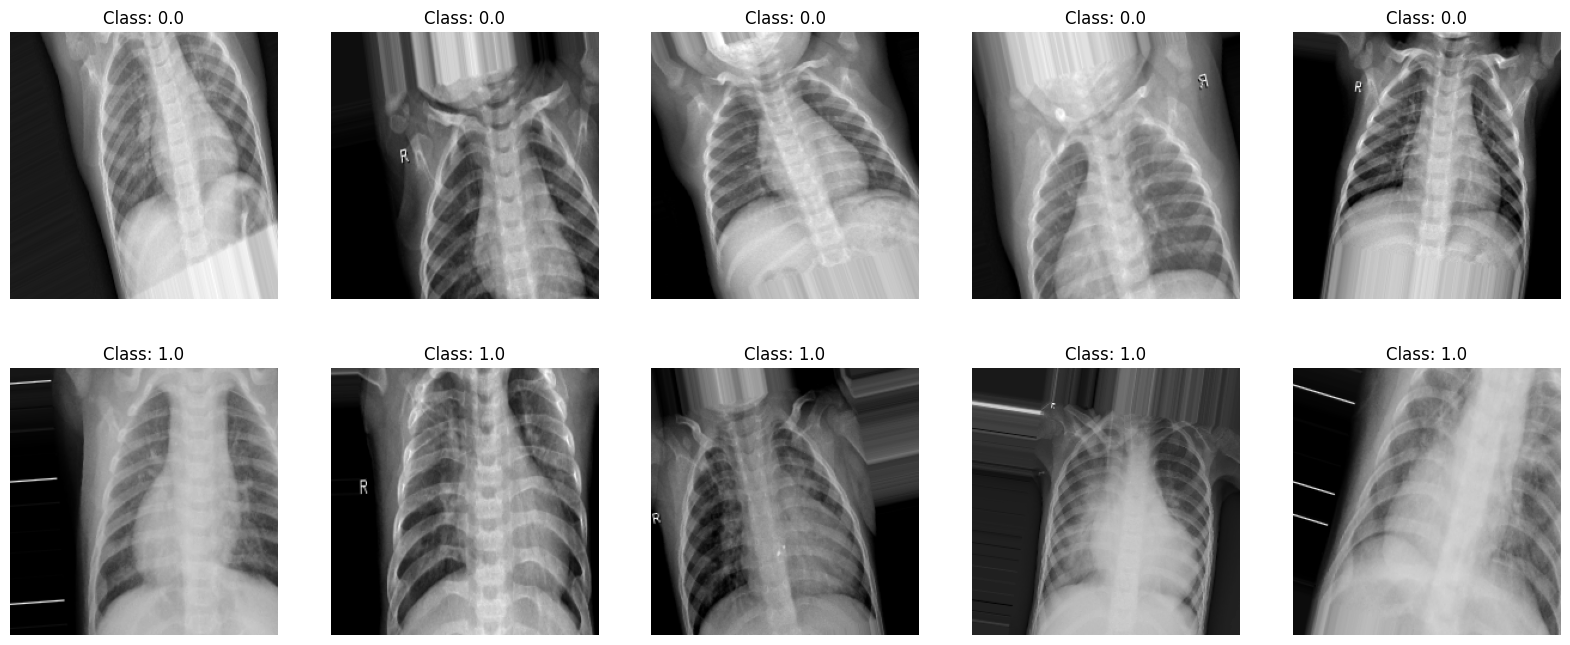

Sample augmented images from the training set:


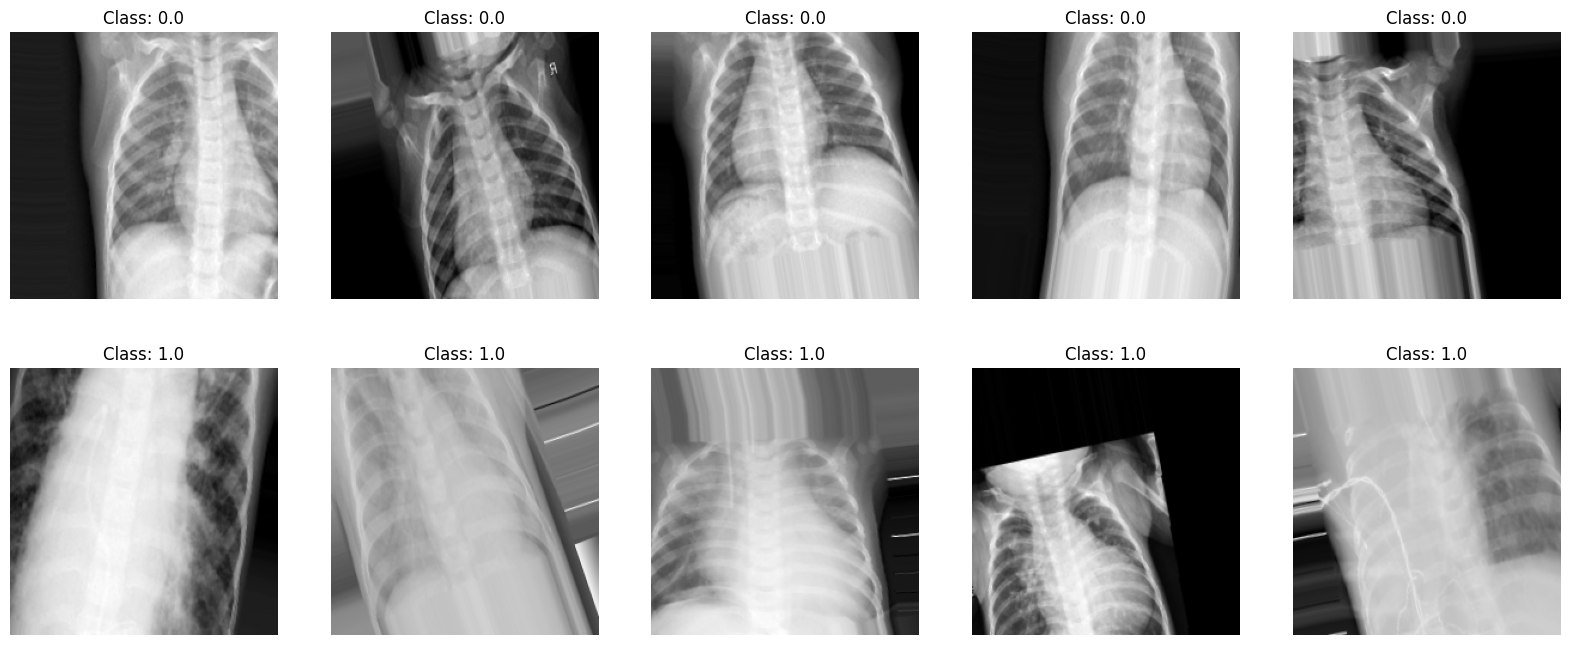

In [ ]:
# Defining image dimensions
img_width, img_height = 224, 224

# Creating an ImageDataGenerator for training data with augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Normalize pixel values to [0,1]
    rotation_range=20,  # Random rotation
    width_shift_range=0.2,  # Random horizontal shift
    height_shift_range=0.2,  # Random vertical shift
    horizontal_flip=True,  # Random horizontal flip
    zoom_range=0.2  # Random zoom
)

# Setting up generators for train split
train_generator = train_datagen.flow_from_directory(
    os.path.join("Final_DataSet", 'train'),
    target_size=(img_width, img_height),
    batch_size=32,
    class_mode='binary',
    color_mode='grayscale',  # Converting each image to grayscale
    shuffle=False  # Disabling shuffling to get the same images
)

# created a Function to display sample images from both classes
def display_images(generator, num_images=5, is_augmented=False):
    plt.figure(figsize=(20, 8))
    images, labels = next(generator)
    class_0_count = class_1_count = 0
    i = 0
    while class_0_count < num_images or class_1_count < num_images:
        if i >= len(images):
            images, labels = next(generator)
            i = 0
        image = images[i]
        label = labels[i]
        if (label == 0 and class_0_count < num_images) or (label == 1 and class_1_count < num_images):
            ax = plt.subplot(2, num_images, (1 if label == 0 else num_images+1) + (class_0_count if label == 0 else class_1_count))
            if is_augmented:
                image = train_datagen.random_transform(image)
            plt.imshow(image.reshape(img_width, img_height), cmap='gray')
            plt.title(f"Class: {labels[i]}")
            plt.axis('off')
            if label == 0:
                class_0_count += 1
            else:
                class_1_count += 1
        i += 1
    plt.show() # Displaying the images


# Displaying sample preprocessed and augmented images from the training set
print("Sample preprocessed images from the training set:\n")
display_images(train_generator)
print("Sample augmented images from the training set:")
display_images(train_generator, is_augmented=True)
